In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
import importlib.machinery
import types
import os
import pickle
from shapely import wkt, geometry
import json
import numpy as np
from copy import deepcopy
from IPython.core.debugger import set_trace
import sys; sys.path.append("../../ddsl")

# from transform import simplex_ft_gpu, simplex_ft_bw_gpu
from ddsl import *

from loader import poly2ve

MEAN = 0.14807655
STD = 0.36801067

class PolyMNIST(object):
    def __init__(self, path):
        with open(os.path.join(path, "mnist_polygon_test.json"), 'r') as infile:
            self.plist = json.load(infile)
        with open(os.path.join(path, "mnist_label_test.json"), 'r') as infile:
            self.label = json.load(infile)
    def __getitem__(self, idx):
        P = wkt.loads(self.plist[idx])
        V, E = poly2ve(P)
        return V, E, self.label[idx]
    
    def get_poly(self, idx):
        P = wkt.loads(self.plist[idx])
        return P
    
    def get_label(self, idx):
        return self.label[idx]


class ShapeOptimizer(object):
    def __init__(self, polygon, C, model, target_cls, device):
        """
        object for optimizing polygonal shapes (MNIST experiment)
        params:
        polygon: shapely Polygon or MultiPolygon object.
        C: shape (#C, 2) control points
        model: trained pytorch model for inference.
        target_cls: int. target class to convert to.
        device: pytorch device type
        """
        self.CPoly = CPolygon(polygon, C)
        self.V = self.CPoly.V
        self.E = self.CPoly.E
        self.polygon = [polygon]
#         self.D = np.ones((self.E.shape[0], 1))
        self.D = torch.ones(self.E.shape[0], 1, dtype=torch.float64)
        self.model = model
        self.target_tensor = torch.tensor([target_cls]).to(device)
        self.dV = None
        self.dC = None
        self.res = self.model.module.signal_sizes[0]
        self.profile = {"loss": [],
                        "class": [],
                        "confidence": []}
        
    def step(self, step_size=1e-3, sign=-1, stochastic=False):
        '''
        combines _get_grad and _step.
        sign = 1 for maximizing score
        sign = -1 for minimizing score
        '''
        assert(sign==1 or sign==-1)
        self._get_grad()
        self._step(step_size=step_size, sign=sign, stochastic=stochastic)

    def _step(self, step_size=1e-3, sign=-1, stochastic=False):
        """
        Take a step toward gradient direction. 
        params:
        step_size: gradient step size
        sign: 1 or -1, to go maximize or minimize value
        check: bool. whether to enforce no-intersection constraint
        shuffle: whether to traverse points in random order during checked updates
        """
        dC = self.dC.copy()
        if not stochastic:
            dC[:, -1] *= 100
            self.CPoly.update_control(sign * step_size * dC)
        else:
            dC = np.sign(dC)
            dC[:, -1] *= 30
            self.CPoly.update_control(sign * step_size * dC)
        self.V = self.CPoly.V
        self.polygon.append(deepcopy(self.CPoly.polygon))

    def _get_grad(self):
        """
        Compute gradient of loss function w.r.t. into vertices
        params:
        self
        """
#         # compute frequencies from V, E
#         Freq = simplex_ft_gpu(self.V, self.E, self.D, (self.res+2, self.res+2), t=(1,1), j=2)
#         Freq = np.squeeze(Freq)
#         half = int(self.res/2+1)
#         Freq = np.concatenate((Freq[:half], Freq[half+2:]), axis=0)
#         Freq = np.stack([np.real(Freq), np.imag(Freq)], axis=-1).astype(np.float32)
#         Freq = np.expand_dims(np.expand_dims(Freq, 0), 0) # pad to shape (batch(1), channel(1), res, res)
#         F_ten = torch.tensor(Freq, requires_grad=True)

        # convert polygon vertices to physical image w/ DDSL
        ddsl_phys=DDSL_phys((self.res,self.res),(1,1),2,1)
        self.V=torch.tensor(self.V, dtype=torch.float64, requires_grad=True)
        self.E=torch.LongTensor(self.E)
        f = ddsl_phys(self.V,self.E,self.D)
        
        # compute loss wrt. target class
        self.model = self.model.double()
        self.model.eval()
        model.zero_grad()
        logits = self.model(f)
        loss = F.cross_entropy(logits, self.target_tensor)
        prob = F.softmax(logits, dim=1)
        _, pred = torch.max(logits.data, 1)
        loss.backward()
        self.profile['loss'].append(loss.item()) # save loss at current iteration
        self.profile['class'].append(pred.item())
        self.profile['confidence'].append(prob[0, pred.item()].item())

        # compute grad on V
#         dF = np.squeeze(F_ten.grad.detach().cpu().numpy()) # shape (28, 15, 2 (real+imag))
#         dF = dF[..., 0] + (1j)*dF[..., 1]
#         dF = dF[:, :-1] # shape (28, 14)
#         dF = np.expand_dims(dF, axis=-1) # shape (28, 14, 1)
#         self.dV = simplex_ft_bw_gpu(dF, self.V, self.E, self.D, (self.res, self.res), t=(1,1), j=2)
#         self.dV = self.dV[:self.V.shape[0]]
        self.dV = self.V.grad.detach().cpu().numpy()
        
        # compute grad on C
        dVdC = self.CPoly.dVdC
        self.dC = np.einsum("ijkl,ij->kl", dVdC, self.dV)
                
        
class CPolygon(object):
    def __init__(self, polygon, C):
        self.polygon = polygon
        self.V, self.E, self.E_segs = self.getVE()
        self.npoly = len(self.E_segs)
        self.C = C
        self.W = None # shape (#V, #C)
        self.dVdC = None # shape (#V, 2, #C, 3)
        self._update_weights()
        
    def update_control(self, dC, rad=True):
        """dC: shape (#C, 3), where 3 dims are x, y, theta"""
        assert(self.C.shape[0] == dC.shape[0])
        dtheta = dC[:, 2].copy()
        dC = dC[:, :2].copy()
        if not rad:
            dtheta = dtheta / 180 * np.pi
        Vnew = np.zeros_like(self.V)
        for i in range(dtheta.shape[0]):
            t = dtheta[i]
            Rot = np.array([[np.cos(t), -np.sin(t)],
                            [np.sin(t), np.cos(t)]])
            a, b = self.C[i]
            Rot_trans = np.array([-a*np.cos(t)+b*np.sin(t)+a,
                                  -a*np.sin(t)-b*np.cos(t)+b])
            Vnew += self.W[:, i:i+1] * (self.V.dot(Rot.T) + dC[i] + Rot_trans)
        self.V = Vnew # update vertices
        self.C += dC # update control points
        self.polygon = self.newPolygon(self.V) # update polygon
        self._update_weights() # update weights and sensitivity matrix

    def _update_weights(self):
        self.W = np.zeros([self.V.shape[0], self.C.shape[0]])
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                v = self.V[i]
                c = self.C[j]
                self.W[i,j] = 1/(np.linalg.norm(c-v)**2)
        # normalize
        self.W = (self.W.T / np.sum(self.W, axis=1)).T
        # compute sensitivity matrix
        nV = self.V.shape[0]
        nC = self.C.shape[0]
        self.dVdC = np.zeros([nV, 2, nC, 3])
        vx, vy = self.V[:, 0:1], self.V[:, 1:2]
        cx, cy = self.C[:, 0], self.C[:, 1]
        # d vx / d cx
        self.dVdC[:, 0, :, 0] = self.W
        # d vy / d cy
        self.dVdC[:, 1, :, 1] = self.W
        # d vx / d ctheta
        self.dVdC[:, 0, :, 2] = self.W * (-vy+cy)
        # d vy / d ctheta
        self.dVdC[:, 1, :, 2] = self.W * (vx-cx)
        
        
    def edgeList(self, startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
        
    def singlePolygon(self, P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = self.edgeList(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = self.edgeList(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e_segs = e
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e, e_segs
    
    def getVE(self):
        E_segs = []
        if isinstance(self.polygon, geometry.polygon.Polygon):
            V, E, e_segs = self.singlePolygon(self.polygon)
            E_segs.append(e_segs)
        elif isinstance(self.polygon, geometry.multipolygon.MultiPolygon):
            V = []
            E = []
            E_segs = []
            ecount = 0
            for P in self.polygon.geoms:
                v, e, e_segs = self.singlePolygon(P)
                V.append(v)
                E.append(e+ecount)
                for s in e_segs:
                    s += ecount
                E_segs.append(e_segs)
                ecount += v.shape[0]
            V = np.concatenate(V, axis=0)
            E = np.concatenate(E, axis=0)
            
        return V, E, E_segs
    
    def newPolygon(self, V):
        np.testing.assert_array_equal(V.shape, self.V.shape)
        polys = []
        for loops in self.E_segs:
            # exterior loop
            ext_loop = loops[0][:, 0]
            ext_v = geometry.asLinearRing(V[ext_loop])
            ints_v = []
            for i in range(1, len(loops)):
                int_loop = loops[i][:, 0]
                int_v = geometry.asLinearRing(V[int_loop])
                ints_v.append(int_v)
            poly = geometry.Polygon(ext_v, ints_v)
            polys.append(poly)
        if len(polys) == 1:
            return polys[0]
        else:
            return geometry.MultiPolygon(polys)
            

In [3]:
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from numpy import asarray, concatenate, ones
from shapely.geometry import *

def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

def showPolygon(polygon):
    fig = plt.figure(num=1, figsize=(4, 4))
    ax = fig.add_subplot(111)

    path = pathify(polygon)
    patch = PathPatch(path, facecolor='#cccccc', edgecolor='#999999')

    ax.add_patch(patch)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1.0)
    
    return fig, ax    

Original Label: 1


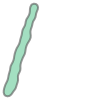

In [4]:
# parse arguments
parser = argparse.ArgumentParser(description='MNIST shape optimization')
parser.add_argument('-l', '--logdir', type=str, default="log", help='log directory path')
parser.add_argument('-s', '--step_size', type=float, default=1e-3, help='step size for shape optimization')
parser.add_argument('--no_cuda', action='store_true', help='do not use cuda')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')

args = parser.parse_args('')

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

# Load the model
loader = importlib.machinery.SourceFileLoader('LeNet5', os.path.join(args.logdir, "model.py"))
mod = types.ModuleType(loader.name)
loader.exec_module(mod)

model = mod.LeNet5(mean=MEAN, std=STD)
if use_cuda:
    model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load(os.path.join(args.logdir, "checkpoint_final.pth.tar"))['state_dict'])

# Shape Optimization
pmnist = PolyMNIST("data/polyMNIST")
P = pmnist.get_poly(2)
label = pmnist.get_label(2)
# control points
C = np.array([[0.61, 0.8],
              [0.57, 0.7],
              [0.54, 0.6],
              [0.52, 0.5],
              [0.48, 0.4],
              [0.45, 0.3],
              [0.43, 0.2],
              [0.40, 0.15]])
print("Original Label: {}".format(label))
optim = ShapeOptimizer(P, C, model, target_cls=3, device=device)
optim.polygon[0]

In [5]:
np.savetxt('example.txt',C)

In [6]:
%matplotlib inline

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import pandas as pd

savefile = 'optim'
mean = 0.14807655
std = 0.36801067
step_size=2e-3

fig, ax = showPolygon(optim.polygon[-1])
plt.close()

def update(frame_number, ax, step_size, savefile, mean, std, optim):
    if frame_number > 0:
        optim.step(step_size, sign=-1, stochastic=True)   
    path = pathify(optim.polygon[-1])
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')
    ax.cla()
    ax.add_patch(patch)
    if frame_number > 0:
        title = "Iter: {}, Loss: {:.4f}, Pred: {}, Prob: {:4f}".format(frame_number, optim.profile['loss'][-1], optim.profile['class'][-1], optim.profile['confidence'][-1])
    else:
        title = "Iter: {0}".format(frame_number)
    ax.set_title(title)
    print(title)
anim = animation.FuncAnimation(fig, update, interval=10, frames=100, fargs=[ax, step_size, savefile, mean, std, optim])

# save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=1800)
anim.save(savefile+'.mp4', writer=writer)

# save loss and pred
pd.DataFrame(optim.profile).to_csv(savefile+'.csv')


/home/maxjiang/Software/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Iter: 0
Iter: 0


RuntimeError: shape '[-1, 1, 28, 28]' is invalid for input of size 196

In [ ]:
for i in range(0,len(optim.polygon)):
  x,y=optim.polygon[i].exterior.xy
  plt.plot(x,y)
plt.scatter(C[:,0], C[:,1])
# plt.ylim([0,1])
# plt.xlim([0,1])
optim.polygon[-1]

<IPython.core.display.Javascript object>


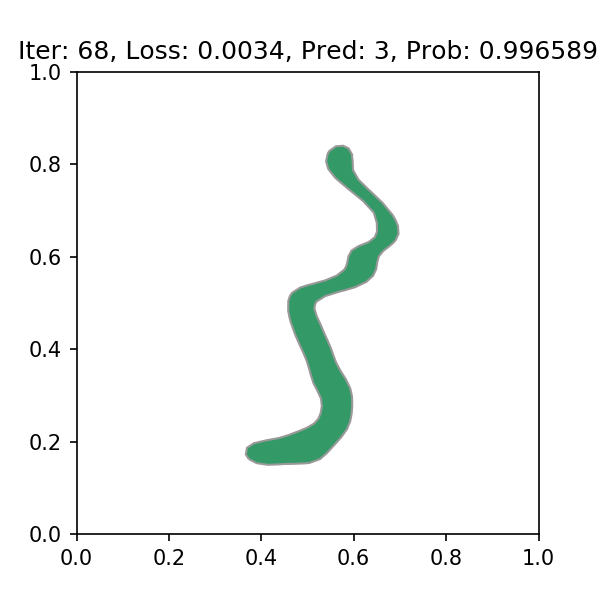

In [22]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = showPolygon(optim.polygon[-1])
plt.show()

def update(frame_number):
    if frame_number > 0:
        optim.step(2e-3)
    path = pathify(optim.polygon[-1])
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')
    ax.cla()
    ax.add_patch(patch)
    if frame_number > 0:
        ax.set_title("Iter: {}, Loss: {:.4f}, Pred: {}, Prob: {:4f}".format(frame_number, optim.profile['loss'][-1], optim.profile['class'][-1], optim.profile['confidence'][-1]))
    else:
        ax.set_title("Iter: {0}".format(frame_number))
    print("Iter: {0}".format(frame_number), end='\r')
anim = FuncAnimation(fig, update, interval=100, frames=150)

In [9]:
HTML(anim.to_html5_video())

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


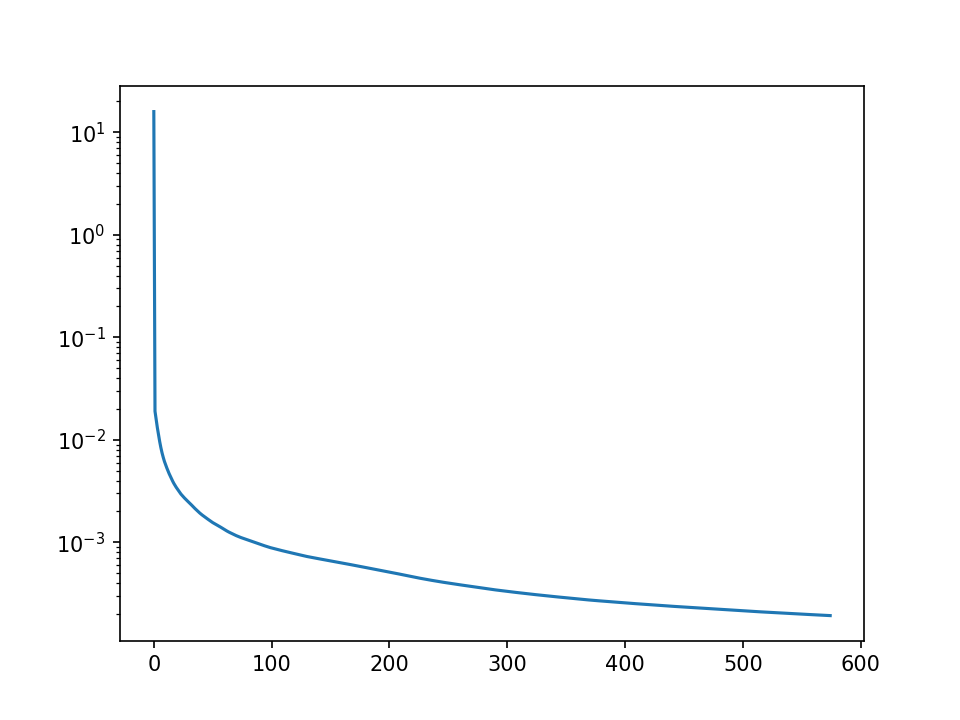

In [10]:
plt.figure()
plt.semilogy(np.arange(len(optim.profile['loss'])), optim.profile['loss'])
plt.show()

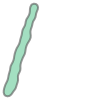

In [18]:
optim.polygon[0]

<IPython.core.display.Javascript object>


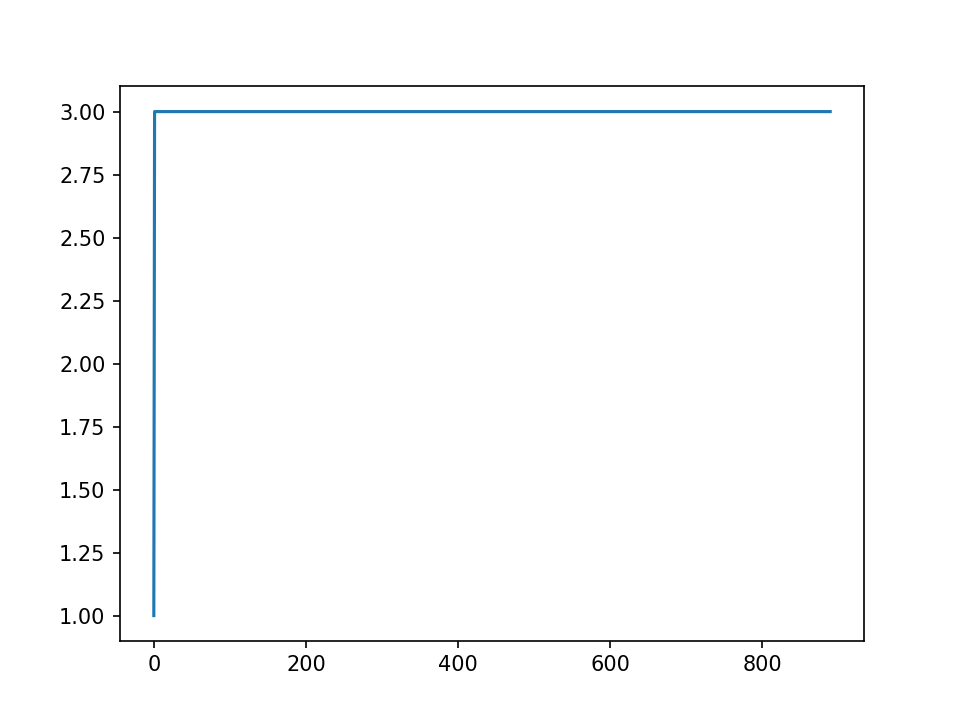

In [15]:
plt.figure()
plt.plot(np.arange(len(optim.profile['class'])), optim.profile['class'])
plt.show()

<IPython.core.display.Javascript object>


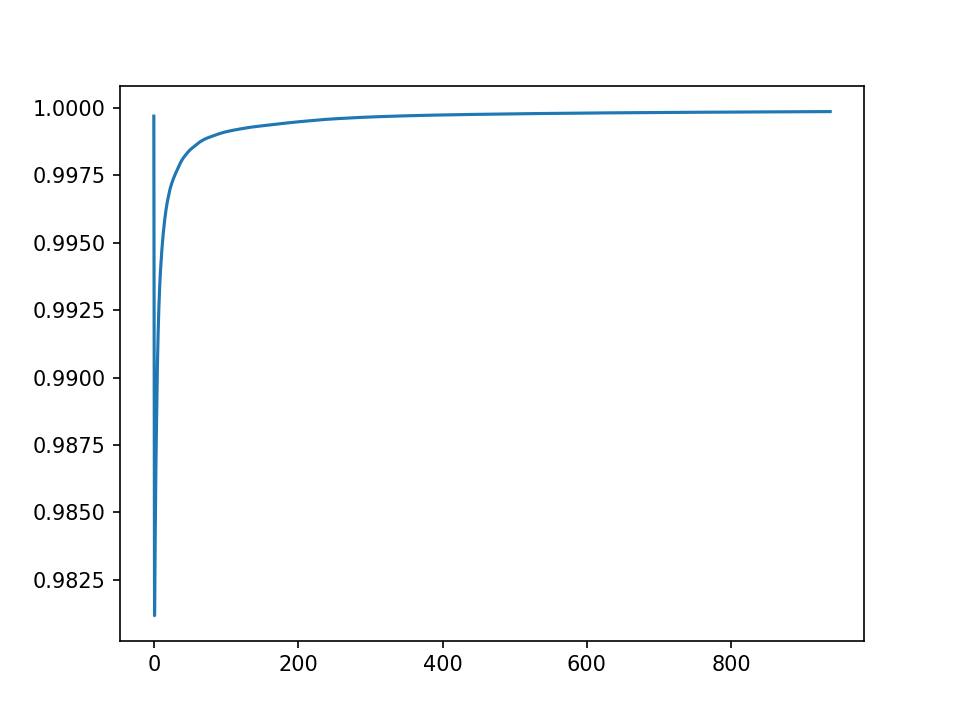

In [16]:
plt.figure()
plt.plot(np.arange(len(optim.profile['confidence'])), optim.profile['confidence'])
plt.show()